In [2]:
import torch
from model import UNet
from dataset import RetinaDataset
from utils import load_data
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models_pytorch as smp
import warnings

warnings.filterwarnings("ignore")

EXP_ID = 18808

MODEL_PATH = f"/scratch/y.aboelwafa/Retina/Retina_Blood_Vessel_Segmentation/checkpoints/pytorch_{EXP_ID}.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(3, 1)
model.to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device("cpu")))

/home/y.aboelwafa/.conda/envs/cv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


<All keys matched successfully>

In [3]:
show_imgs = 1
test_transform = A.Compose(
    [
        A.Resize(512, 512),
    ]
)
train_images, train_masks, test_images, test_masks = load_data("dataset")
test_dataset = RetinaDataset(test_images, test_masks, transform=test_transform)

In [4]:
def connected_components(img, min_threshold=0.2, max_threshold=0.5):

    _, sure_edges = cv2.threshold(img, max_threshold, 1, cv2.THRESH_BINARY)

    uncertain_edges = np.logical_and(img > min_threshold, img < max_threshold).astype(
        np.uint8
    )

    combined_edges = np.logical_or(sure_edges, uncertain_edges).astype(np.uint8)

    num_combined, combined_components = cv2.connectedComponents(
        combined_edges, connectivity=8
    )

    sure_labels = np.zeros_like(combined_components, dtype=np.uint8)
    sure_labels = combined_components * sure_edges
    selected_labels = np.unique(sure_labels)

    mask = np.isin(combined_components, selected_labels)
    filtered_combined = combined_components * mask
    filtered_combined = np.where(filtered_combined > 0, 1, 0)

    return filtered_combined

IoU Score before hysteresis thresholding =  0.6876556277275085


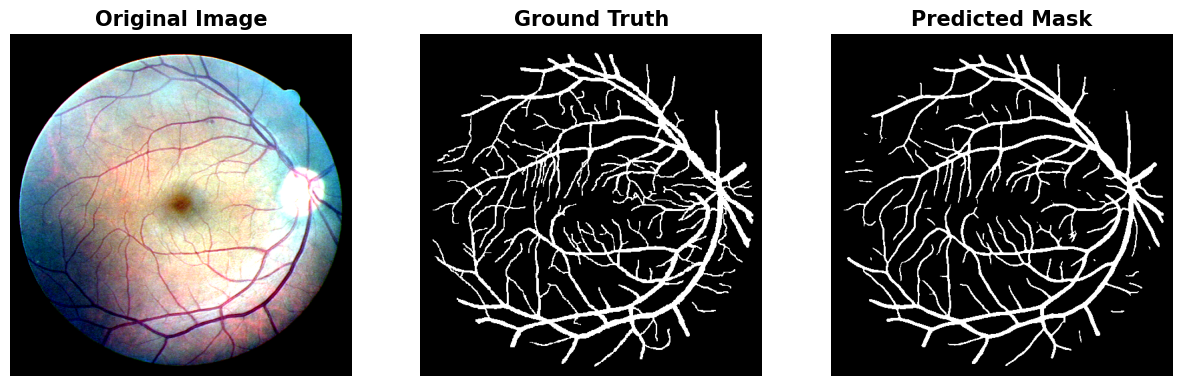

IoU Score after hysteresis thresholding =  0.6974155306816101


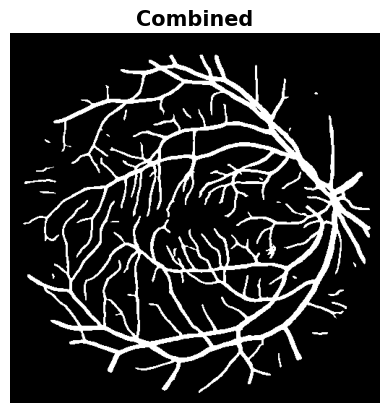

In [8]:
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)
for i in range(show_imgs):
    img, mask = test_dataset[random_list[i]]
    img = img.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)
    pred = model(img)
    pred = torch.sigmoid(pred)
    mask = mask.round().long()

    tp, fp, fn, tn = smp.metrics.get_stats(pred, mask, mode="binary", threshold=0.5)  # type: ignore
    iou_before = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()

    img = img.squeeze().permute(1, 2, 0).numpy()
    mask = mask.squeeze().numpy()
    pred = pred.squeeze().detach().numpy()

    combined = connected_components(pred)

    print("IoU Score before hysteresis thresholding = ", iou_before)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    pred = pred > 0.5

    ax[0].imshow(img)
    ax[0].set_title("Original Image", fontsize=15, weight="bold")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Ground Truth", fontsize=15, weight="bold")
    ax[1].axis("off")

    ax[2].imshow(pred, cmap="gray")
    ax[2].set_title("Predicted Mask", fontsize=15, weight="bold")
    ax[2].axis("off")

    plt.show()

    mask = torch.tensor(mask).unsqueeze(0).unsqueeze(0).to(device)
    combined_tensor = torch.tensor(combined).unsqueeze(0).unsqueeze(0).float().to(device)

    tp, fp, fn, tn = smp.metrics.get_stats(combined_tensor, mask, mode="binary", threshold=0.5) # type: ignore
    iou_after = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
    print("IoU Score after hysteresis thresholding = ", iou_after)

    plt.imshow(combined, cmap="gray")
    plt.title("Combined", fontsize=15, weight="bold")
    plt.axis("off")

    plt.show()